# Import libraries and loading some tables

In [2]:
import numpy as np
import pandas as pd
import seaborn as snb
import matplotlib.pyplot as plt

%matplotlib inline

## Loading tables to work sapce
master = pd.read_csv('C:/Users/Shahrooz/Desktop/BaseBall_Analysis_Project/baseballdatabank-master/core/Master.csv')
batting = pd.read_csv('C:/Users/Shahrooz/Desktop/BaseBall_Analysis_Project/baseballdatabank-master/core/Batting.csv')
pitching = pd.read_csv('C:/Users/Shahrooz/Desktop/BaseBall_Analysis_Project/baseballdatabank-master/core/Pitching.csv')
salaries = pd.read_csv('C:/Users/Shahrooz/Desktop/BaseBall_Analysis_Project/baseballdatabank-master/core/Salaries.csv')

###### Base on our data, I am focusing on these questions:
###### 1. How players salaries is distributed? is it normal or skewd?
###### 2. How to measure financial efficiency of teams base on their payroll?
###### 3. Who is the most paid palyers in 2015 as a pitcher?
###### 4. Which key features of the most paid pitcher is significantly different from other pitchers?
###### 5. Who is the most paid palyers in 2015 as a batter?
###### 6. Which key features of the most paid batter is significantly different from other batters?
###### 7. What is the trend of changing salaries over the time?
###### 8. How does number of wins change over time?
###### 9. Is there any difference between Batters and Pitchers Salary on average?
###### 10. What's the best model for describing wins for each team? Which features are best relate to wins?

# 1. Salaries Distribution

###### First look at Salaries stats; Because of the salary change over the years, we will focus on years after 2010;

In [3]:
salaries_after_2010 = salaries[salaries['yearID'] >= 2010]
salaries_after_2010['salary'].describe()

count    4.951000e+03
mean     3.671903e+06
std      4.909905e+06
min      4.000000e+05
25%      5.040000e+05
50%      1.300000e+06
75%      5.000000e+06
max      3.300000e+07
Name: salary, dtype: float64

###### Looking at salaries histogram from 1985 to 2015

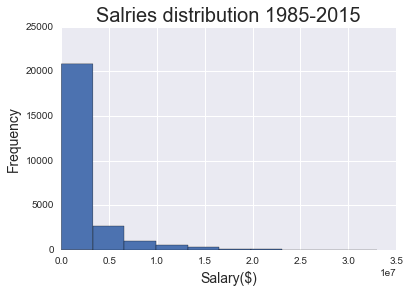

In [88]:
salaries['salary'].plot.hist()
plt.title('Salries distribution 1985-2015', fontsize=20)
plt.xlabel('Salary($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

###### It seems like the salaries are very skewed, for making sure that the result is correct, we will look at the latest 5 years:

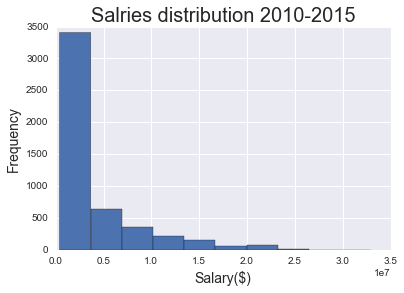

In [75]:
salaries_after_2010['salary'].plot.hist()
plt.title('Salries distribution 2010-2015', fontsize=20)
plt.xlabel('Salary($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

###### For measuring the skewness of salary, I will use Pearson's second skewness coefficient (median skewness):

In [7]:
yearly_mean = salaries.groupby('yearID').mean()
yearly_median = salaries.groupby('yearID').median()
yearly_std = salaries.groupby('yearID').std()
meadian_skewness = 3 * (yearly_mean - yearly_median)/ yearly_std
print 'Yearly Salaries median Skewness is :', meadian_skewness['salary'].mean()

Yearly Salaries median Skewness is : 1.39159693472


#### It means that Salaries are Positively Skewed. Because the median skewness is positive.

# 2. Teams Payroll vs. number of their Wins
##### What is the ratio of wins to total payroll of each team in each year?

In [8]:
teams = pd.read_csv('C:/Users/Shahrooz/Desktop/BaseBall_Analysis_Project/baseballdatabank-master/core/Teams.csv')
teams_after_1985 = teams[teams['yearID']>= 1985]
teams_after_1985 = teams_after_1985[['yearID', 'teamID', 'Rank', 'R', 'RA', 'G', 'W', 'L', 'H', 'BB', 'HBP', 'AB', 'SF', 'HR', '2B', '3B']]
teams_after_1985 = teams_after_1985.set_index(['yearID','teamID'])
salaries_yearID_teamID = salaries.groupby(['yearID', 'teamID'])['salary'].sum()
teams_after_1985 = teams_after_1985.join(salaries_yearID_teamID)

###### For having an idea of how payroll relates to number of wins, look at this scatter plot:

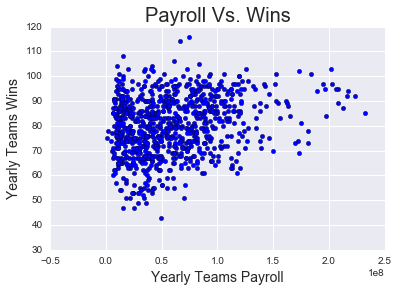

In [96]:
plt.scatter(teams_after_1985['salary'], teams_after_1985['W'])
plt.title('Payroll Vs. Wins', fontsize=20)
plt.xlabel('Yearly Teams Payroll', fontsize=14)
plt.ylabel('Yearly Teams Wins', fontsize=14)

###### For measuring financial efficiency for teams, we need a criteria. So I defined the ratio of number of Wins to total Payroll and multiply it to 1e6 to have more reasonable numbers. 

In [11]:
# defining a function base on a measure for comparing teams base on Payroll and Wins for a year
def most_efficient_team(year):
    team_efficiency = (teams_after_1985['W']/teams_after_1985['salary']) * 10**6
    return (team_efficiency[year].argmax(), team_efficiency[year].loc[team_efficiency[year].argmax()])

result = pd.Series()
for i in range(2000, 2016):
    result = result.append(pd.Series([most_efficient_team(i)], index = [i]))

result

2000    (MIN, 4.17688186688)
2001    (MIN, 3.52258599254)
2002    (OAK, 2.57473177732)
2003    (TBA, 3.20937340805)
2004    (MIL, 2.43384129175)
2005    (TBA, 2.25748336361)
2006     (FLO, 5.3164298129)
2007    (TBA, 2.73592140444)
2008     (FLO, 3.8511794237)
2009    (FLO, 2.36194820003)
2010    (SDN, 2.38099647348)
2011    (TBA, 2.21661594311)
2012    (OAK, 1.69759357082)
2013    (HOU, 2.85064307154)
2014    (HOU, 1.99337629534)
2015    (ARI, 1.27761425753)
dtype: object

###### Base on the above results, we can find out which teams are the most efficient in each year, reffer to their total payroll and number of wins they have in that year. As we see in year 2002 the Oaklans A's is the most efficient team; It was in the Billy Beane era and starting using analysis for recrutement. In 2002, the Athletics became the first team in the 100 plus years of American League baseball to win 20 consecutive games. The nice point is that they got this record with a very low payroll.

# 3. The most paid Pitcher in 2015

###### Because I want to find out the most salary paid to pitchers, I should add salary column to pitching table. And We have salaries after 1985, so we should slice pitching table only for after that year. Here is the merge result:

In [106]:
# slicing data on years after 1985
pitching = pitching[pitching['yearID'] >= 1985]
# claiming keys I want two tables merge on them;
pitching_salary = pitching.merge(salaries, on = ['yearID', 'playerID', 'teamID', 'lgID'], how = 'left')
pitching_salary.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary
0,aasedo01,1985,1,BAL,AL,10,6,54,0,0,0,14,264.0,83,37,6,35,67,0.25,3.78,7.0,0.0,1.0,1,366.0,43.0,44,NaN,NaN,NaN,NaN
1,abregjo01,1985,1,CHN,NL,1,1,6,5,0,0,0,72.0,32,17,3,12,13,0.35,6.38,1.0,0.0,0.0,0,109.0,0.0,18,NaN,NaN,NaN,NaN
2,ackerji01,1985,1,TOR,AL,7,2,61,0,0,0,10,259.0,86,31,7,43,42,0.26,3.23,1.0,2.0,3.0,0,370.0,26.0,35,NaN,NaN,NaN,170000.0
3,agostju01,1985,1,CHA,AL,4,3,54,0,0,0,1,181.0,45,24,3,23,39,0.21,3.58,1.0,0.0,3.0,0,246.0,21.0,27,NaN,NaN,NaN,147500.0
4,aguilri01,1985,1,NYN,NL,10,7,21,19,2,0,0,367.0,118,44,8,37,74,0.25,3.24,2.0,5.0,2.0,2,507.0,1.0,49,NaN,NaN,NaN,NaN


In [107]:
max_pitching_salary_index = pitching_salary['salary'].argmax()
max_pitch_playerID = pitching_salary['playerID'].loc[max_pitching_salary_index]
pitching_salary.loc[max_pitching_salary_index]

playerID     kershcl01
yearID            2015
stint                1
teamID             LAN
lgID                NL
W                   16
L                    7
G                   33
GS                  33
CG                   4
SHO                  3
SV                   0
IPouts             698
H                  163
ER                  55
HR                  15
BB                  42
SO                 301
BAOpp            0.194
ERA               2.13
IBB                  1
WP                   9
HBP                  5
BK                   3
BFP                890
GF                   0
R                   62
SH                   4
SF                   0
GIDP               NaN
salary      3.2571e+07
Name: 18743, dtype: object

###### First and Last name of the most paid Pitcher in 2015:

In [108]:
master[master['playerID'] == max_pitch_playerID][['nameFirst', 'nameLast']]

,nameFirst,nameLast
8937,Clayton,Kershaw


# 4. Key Characteristics of the Most paid Pitcher

###### For the most paid pitcher, I want to see what characteristics are significantly different from other pitchers. For this reason we need to calculate the Z-Value for all featurs and find out which of them are more than 3. It means these variables are 3 Standard deviation times more than mean in each column.

###### Defining functions to calculate Z-Value for numeric columns in a dataframe.

In [15]:
def z_value_column(data):
    return (data-data.mean())/data.std(ddof = 0)

def z_value_df(df):
    # in our 2 major dataframes(pitching and batting) all numeric values start from 5th column
    newdf = df[df.columns[5:]]
    return newdf.apply(z_value_column)

In [16]:
pitching_after_2010 = pitching_salary[pitching_salary['yearID'] >= 2010]
z_val_pitching = z_value_df(pitching_after_2010)
z_val_pitching.head()

,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary
14765,-0.791811,0.727129,1.262863,-0.617172,-0.271084,-0.231219,4.393969,-0.162335,-0.421766,-0.268484,...,-0.097742,-0.051827,-0.389058,-0.200315,3.416471,-0.326997,1.975745,-0.352353,NaN,-0.130422
14766,-0.791811,-0.628409,-0.201321,-0.617172,-0.271084,-0.231219,-0.257115,-0.674777,-0.748779,-0.770706,...,-0.828147,-0.809485,-0.389058,-0.704834,-0.042164,-0.790374,-0.768811,-0.352353,NaN,NaN
14767,-0.791811,-0.628409,-1.004260,-0.617172,-0.271084,-0.231219,-0.257115,-0.880868,-0.783202,-0.770706,...,-0.097742,-0.430656,-0.389058,-0.873008,-0.416071,-0.790374,-0.768811,-0.846683,NaN,-0.499361
14768,-0.075874,-0.899517,-0.768102,-0.617172,-0.271084,-0.231219,-0.107080,-0.791748,-0.817624,-0.847971,...,-0.828147,-0.430656,-0.389058,-0.796929,-0.416071,-0.826018,-0.768811,-0.846683,NaN,-0.641711
14769,-0.075874,-0.357302,0.696082,-0.617172,-0.271084,-0.231219,-0.107080,-0.329435,-0.473399,-0.500279,...,0.267460,-0.809485,-0.389058,-0.380500,0.518695,-0.540863,-0.376732,-0.352353,NaN,NaN


In [17]:
# For having year and player ID (the non numeric columns) we need to slice the original dataframe
year_player_pitch = pitching_after_2010.loc[:,['yearID', 'playerID']]

# concatinating the result of z-value dataframe and year and player ID dataframe column-wise
objs = [year_player_pitch, z_val_pitching]
z_val_pitching = pd.concat(objs, axis = 1)

In [111]:
pitch_result = z_val_pitching[(z_val_pitching['playerID'] == max_pitch_playerID) & (z_val_pitching['yearID'] == 2015)]
# I want to see all columns in the screen and avoid ellipses
pd.set_option('display.max_columns', 100)
pitch_result

,yearID,playerID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary
18743,2015,kershcl01,3.026524,0.998236,0.318228,2.45201,5.596618,7.874959,-0.257115,2.895609,1.815696,1.122284,1.259892,1.162541,4.92055,-0.858028,-0.50581,-0.266953,2.458675,1.08466,5.228206,2.554523,-0.603024,1.205711,0.799507,-0.846683,NaN,6.457672


###### Base on above Z-Scores, the most paid pitcher has big Z-scores on : 
### SHO, CG, BK, SO, W;

# 5. The Most paid Batter in 2015

###### Because I want to find out the most salary paid to batters, I should add salary column to batting table. And we have salaries after 1985, so we should slice batting table only for after that year. Here is the merge result:

In [19]:
# slicing data on years after 1985
batting = batting[batting['yearID'] >= 1985]

# claiming keys we want two tables merge on them;
batting_salary = batting.merge(salaries, on = ['yearID', 'playerID', 'teamID', 'lgID'], how = 'left')
batting_salary.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
0,aasedo01,1985,1,BAL,AL,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abregjo01,1985,1,CHN,NL,6,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN
2,ackerji01,1985,1,TOR,AL,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170000.0
3,adamsri02,1985,1,SFN,NL,54,121.0,12.0,23.0,3.0,1.0,2.0,10.0,1.0,1.0,5.0,23.0,3.0,1.0,3.0,0.0,2.0,NaN
4,agostju01,1985,1,CHA,AL,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147500.0


In [20]:
# looking at max Batting Salary
max_batting_salary_index = batting_salary['salary'].argmax()
max_batting_playerID = batting_salary['playerID'].loc[max_batting_salary_index]
batting_salary.loc[max_batting_salary_index]

playerID    rodrial01
yearID           2009
stint               1
teamID            NYA
lgID               AL
G                 124
AB                444
R                  78
H                 127
2B                 17
3B                  1
HR                 30
RBI               100
SB                 14
CS                  2
BB                 80
SO                 97
IBB                 7
HBP                 8
SH                  0
SF                  3
GIDP               13
salary        3.3e+07
Name: 30298, dtype: object

###### First and Last name of the most paid Batter in 2015:

In [21]:
master[master['playerID'] == max_batting_playerID][['nameFirst', 'nameLast']]

,nameFirst,nameLast
14471,Alex,Rodriguez


# 6. Key Characteristics of the Most paid Batter

###### The same explanation for topic number 5 is reasonable for current topic. Except that I am focusing on batters now.

In [22]:
batting_after_2010 = batting_salary[batting_salary['yearID'] >= 2010]
z_value_batting = z_value_df(batting_after_2010)
z_value_batting.head()

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
30612,0.086796,-0.662016,-0.596057,-0.617276,-0.592739,-0.408057,-0.485738,-0.576229,-0.360255,-0.412652,-0.568931,-0.678234,-0.343577,-0.457122,-0.470932,-0.504466,-0.562007,-0.193509
30613,-0.603534,-0.656363,-0.596057,-0.617276,-0.592739,-0.408057,-0.485738,-0.576229,-0.360255,-0.412652,-0.568931,-0.651698,-0.343577,-0.457122,-0.470932,-0.504466,-0.562007,NaN
30614,2.335938,2.576999,2.998236,2.408344,3.551358,0.251160,2.472808,2.661616,3.847959,4.866385,4.189596,2.824520,1.010774,0.369077,-0.470932,2.338602,2.263373,1.073233
30615,0.710321,0.428961,0.057451,0.315278,0.519092,0.251160,-0.337811,-0.036588,-0.009570,0.115251,-0.350148,0.568959,-0.343577,-0.457122,-0.470932,1.769989,1.176688,-0.668385
30616,-0.982103,-0.662016,-0.596057,-0.617276,-0.592739,-0.408057,-0.485738,-0.576229,-0.360255,-0.412652,-0.568931,-0.678234,-0.343577,-0.457122,-0.470932,-0.504466,-0.562007,-0.531982


In [23]:
# For getting back year and player ID I need to slice the original dataframe
year_player_batt = batting_after_2010.loc[:,['yearID', 'playerID']]

# concatinating the result of z-value dataframe and year and player ID dataframe column-wise
objs = [year_player_batt, z_value_batting]
z_val_battinging = pd.concat(objs, axis = 1)

In [24]:
batt_result = z_val_battinging[(z_val_battinging['playerID'] == max_batting_playerID) & (z_val_battinging['yearID'] == 2015)]
# I want to see all columns in the screen and avoid ellipses
pd.set_option('display.max_columns', 100)
batt_result

,yearID,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
38761,2015,rodrial01,2.269132,2.294362,2.794015,2.097493,1.630923,0.25116,4.395863,2.993702,0.341114,-0.412652,4.025509,3.169488,1.913674,2.021473,-0.470932,3.47583,3.13272,3.708055


###### Base on above Z-Scores, the most paid batter has big Z-scores on : 
### HR, RBI, BB, SO, SF, GIDP
###### About this part and the part number 5, I should make it clear that these characteristics are not the cause of big salaries; there is only a chance of correlation between them.

# 7. Yearly Salary Trend

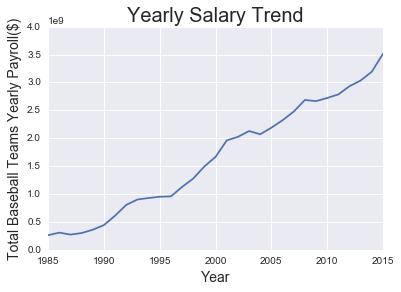

In [92]:
salaries.groupby('yearID').sum()['salary'].plot()
plt.title('Yearly Salary Trend', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Baseball Teams Yearly Payroll($)', fontsize=14)

In [27]:
salaries.groupby('yearID').sum()['salary']

yearID
1985     261964696
1986     307854518
1987     272575375
1988     300452424
1989     359995711
1990     443881193
1991     613048418
1992     805543323
1993     901740134
1994     927836287
1995     951469367
1996     956983550
1997    1127285885
1998    1278282871
1999    1494228750
2000    1666135102
2001    1960663313
2002    2024077522
2003    2128262128
2004    2070665943
2005    2188713398
2006    2321472617
2007    2476688987
2008    2684858670
2009    2664726994
2010    2721359865
2011    2784505291
2012    2932741192
2013    3034525648
2014    3192317623
2015    3514142569
Name: salary, dtype: int64

In [28]:
salary_growth = (salaries.groupby('yearID').sum()['salary'][2015])/(salaries.groupby('yearID').sum()['salary'][1985])
salary_growth

13

###### Base on this graph we can draw the conclustion that the whole yearly payroll in the Baseball teams folded 13 times in recent 30 years.

# 8. Number of Wins Changes Over Time

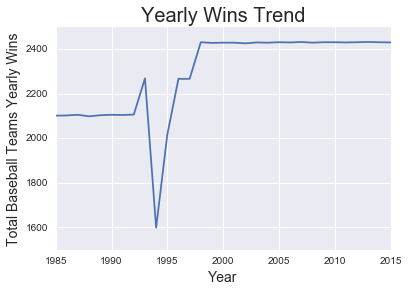

In [93]:
teams_after_85 = teams[teams['yearID']>= 1985]
teams_after_85.groupby('yearID').sum()['W'].plot()
plt.title('Yearly Wins Trend', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Baseball Teams Yearly Wins', fontsize=14)

In [32]:
teams_after_85.groupby('yearID').sum()['W']

yearID
1985    2101
1986    2102
1987    2105
1988    2098
1989    2103
1990    2105
1991    2104
1992    2106
1993    2268
1994    1599
1995    2016
1996    2266
1997    2266
1998    2430
1999    2427
2000    2428
2001    2428
2002    2425
2003    2429
2004    2428
2005    2430
2006    2429
2007    2431
2008    2428
2009    2430
2010    2430
2011    2429
2012    2430
2013    2431
2014    2430
2015    2429
Name: W, dtype: int64

###### It means total number of wins has an absolute growth from 2100 to more than 2400; Year 1994 is an interesting year. There should be a reason for dropping total number of wins in that year.

# 9. Difference between Batters and Pitchers Salaries

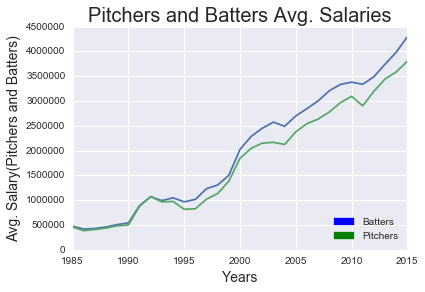

In [94]:
# aggregating over years, and calculation average salary in each year.
bat_avg_salary = batting_salary.groupby('yearID').mean()['salary']
pitch_avg_salary = pitching_salary.groupby('yearID').mean()['salary']

# Plotting these two series
import matplotlib.patches as mpatches
bat_avg_salary.plot()
pitch_avg_salary.plot()
plt.title('Pitchers and Batters Avg. Salaries', fontsize=20)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Avg. Salary(Pitchers and Batters)', fontsize=14)
blue_patch = mpatches.Patch(color='blue', label='Batters')
green_patch = mpatches.Patch(color='green', label='Pitchers')
plt.legend(handles=[blue_patch, green_patch], loc=4)

###### Base on this plot, it seem like the average salary for batters are more than Pitchers. For testing this arbitrary conclusion we can calculate the ratio of these two series and look at the average ratio over years:

In [35]:
batt_to_pitch_salary = bat_avg_salary/pitch_avg_salary
batt_to_pitch_salary.mean()

1.1086679922728646

###### The average batters salary is 11% more than average pitchers salary.

# 10. Modeling Team Wins

###### Base on baseball rules, the winning team has more runs. So the most important criteria for modeling wins is runs. I am looking at correlation between runs and other features for teams and find out the most correlated characteristics.

In [36]:
teams[teams.columns[6:]].corr()['R'].sort_values(ascending = False)

R             1.000000
H             0.801701
2B            0.692903
W             0.677243
BB            0.647082
AB            0.618912
HA            0.594606
ER            0.554383
RA            0.548338
G             0.532620
IPouts        0.519478
SF            0.509470
HR            0.500400
DP            0.474370
BBA           0.468324
FP            0.411579
HRA           0.387560
Ghome         0.353552
ERA           0.317673
SOA           0.307831
SV            0.301986
attendance    0.298650
3B            0.252232
SO            0.250706
BPF           0.233560
HBP           0.231644
SB            0.180675
PPF           0.049879
L             0.028576
SHO          -0.005953
CS           -0.025908
CG           -0.054133
E            -0.131307
Name: R, dtype: float64

###### These numbers suggest that runs has a strong correlation with R and H; R is runs itself and it's obvious any variable has a 100% correlation with itself. H is Hits and again it's an obvious correlation; Because hits are the major cause of runs. The other correlations are not very high, so we will define some new variables and look at their correlation with runs; These new variables are:
###### BA: Batting average
###### OBP: On Base Percentage
###### SLG: Sluggish Percentage

In [37]:
teams['BA'] = teams['H']/teams['AB']
teams['OBP'] = (teams['H'] + teams['BB'] + teams['HBP']) / (teams['AB'] + teams['BB'] + teams['HBP'] + teams['SF'])
teams['SLG'] = (teams['H'] + teams['2B'] + (2*teams['3B']) + (3*teams['HR'])) / teams['AB']

###### calculating the correlation with runs for looking at correlation with new variables

In [38]:
teams[teams.columns[6:]].corr()['R'].sort_values(ascending = False)

R             1.000000
OBP           0.897286
H             0.801701
SLG           0.773514
2B            0.692903
W             0.677243
BA            0.660676
BB            0.647082
AB            0.618912
HA            0.594606
ER            0.554383
RA            0.548338
G             0.532620
IPouts        0.519478
SF            0.509470
HR            0.500400
DP            0.474370
BBA           0.468324
FP            0.411579
HRA           0.387560
Ghome         0.353552
ERA           0.317673
SOA           0.307831
SV            0.301986
attendance    0.298650
3B            0.252232
SO            0.250706
BPF           0.233560
HBP           0.231644
SB            0.180675
PPF           0.049879
L             0.028576
SHO          -0.005953
CS           -0.025908
CG           -0.054133
E            -0.131307
Name: R, dtype: float64

###### Base on these correlation numbers, we conclude that all three new variables have a high correlation with runs. Now is time for doing the modeling. I focus on linear regression and use statsmodels library in python. After several models, the best model would be the model with maximum R-squared;
###### First I will model runs with only BA feature. Because BA was one of the most powerful predictors for runs. After this simple model, I will try several other combinations of most correlated features with runs.

In [39]:
import statsmodels.formula.api as sm

In [40]:
#First Model
runs_reg_model_1 = sm.ols("R~BA",teams)
runs_reg_1 = runs_reg_model_1.fit()
#Second Model
runs_reg_model_2 = sm.ols("R~OBP+SLG+BA",teams)
runs_reg_2 = runs_reg_model_2.fit()
#Third Model
runs_reg_model_3 = sm.ols("R~OBP+SLG",teams)
runs_reg_3 = runs_reg_model_3.fit()

In [41]:
runs_reg_1.rsquared

0.43649242323936921

In [42]:
runs_reg_2.rsquared

0.91720734941792037

In [43]:
runs_reg_3.rsquared

0.91720633065595547

###### Base on R-Squared, the second model is the best fit; So the runs model will have OBP, SLG and BA as features. The parametes are:

In [44]:
runs_reg_2.params

Intercept    -864.826782
OBP          2676.146274
SLG          1741.782535
BA             14.081648
dtype: float64

###### The best model for predicting runs score is:
### R = -864.83 + 2676.15 * OBP + 1741.78 * SLG + 14.08 BA

###### Now I want to compare the model with real data; I am adding another column to teams dataframe that contains our model for Runs: R_Modeled

In [45]:
teams['R_Modeled'] = -864.83 + teams['OBP'] * 2676.15 + teams['SLG'] * 1741.78 + teams['BA'] * 14.08

###### I am focusing on years after 2000:

In [52]:
teams_after_2000 = teams[teams['yearID'] >= 2000]

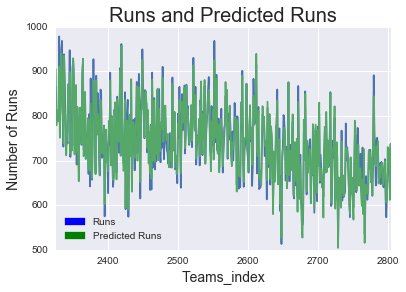

In [95]:
teams_after_2000['R'].plot()
teams_after_2000['R_Modeled'].plot()
plt.title('Runs and Predicted Runs', fontsize=20)
plt.xlabel('Teams_index', fontsize=14)
plt.ylabel('Number of Runs', fontsize=14)
blue_patch = mpatches.Patch(color='blue', label='Runs')
green_patch = mpatches.Patch(color='green', label='Predicted Runs')
plt.legend(handles=[blue_patch, green_patch], loc=3)

In [132]:
runs_reg_1.params

Intercept    -627.937313
BA           5010.095953
dtype: float64

###### The other model for predicting Runs score is:
### R = -627.94 + 5010.09 *  BA

In [86]:
teams['R_Modeled_BA'] = -627.94 + teams['BA'] * 5010.09
teams_after_2000 = teams[teams['yearID'] >= 2000]

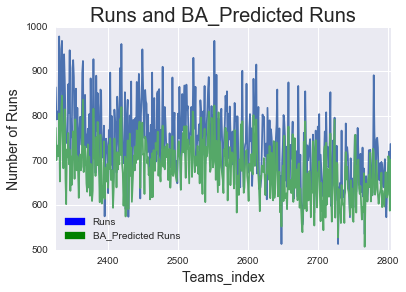

In [87]:
teams_after_2000['R'].plot()
teams_after_2000['R_Modeled_BA'].plot()
plt.title('Runs and BA_Predicted Runs', fontsize=20)
plt.xlabel('Teams_index', fontsize=14)
plt.ylabel('Number of Runs', fontsize=14)
blue_patch = mpatches.Patch(color='blue', label='Runs')
green_patch = mpatches.Patch(color='green', label='BA_Predicted Runs')
plt.legend(handles=[blue_patch, green_patch], loc=3)